### Getting and preprocessing the data
First we get the dataset online, then apply subsampling, then divide the dataset in equally long sentences

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [111]:
%%time
from collections import Counter
import numpy as np
import random
from itertools import dropwhile

def sampling(dataset,threshold=1e-4, min_count=5):
    
    # Count occurences of each word in the dataset 
    word_counts = Counter(dataset)
    total_count = len(dataset)
    
    freqs = {word: count/total_count for word, count in word_counts.items() if count>5 }
    p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts if word_counts[word]>5 }
    print(str(p_drop['the']) + ' this is a test' )
    #train_words = [word for word in dataset if (random.random() < (1 - p_drop[word])) and word_counts[word]>min_count]
    #del dataset
    return p_drop

"Transforms a list of words to a list of sentences with length=len_sen"
def words_to_sentences(words):
    new_ds = []
    len_sen = int(len(words)/1700)
    len_sen = 20
    for i in range(0, len(words), len_sen):
        y = [words[i:i + len_sen]]
        new_ds.extend(y)
    return new_ds
    

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 26.9 µs


In [2]:
### ENWIK9 DATASET

In [3]:
#file = open("./data/enwik9")
enwik9 = file.readlines()
enwik9 = enwik9[0].split()
enwik9 = sampling(enwik9)
enwik9 = words_to_sentences(enwik9)
with open("enwik9_sampled_1e-4_as_list", 'wb') as output:
    pickle.dump(enwik9, output, pickle.HIGHEST_PROTOCOL)

NameError: name 'file' is not defined

In [2]:
import pickle
with open("enwik9_sampled_1e-4_as_list", 'rb') as output:
        enwik9 = pickle.load(output)

### TEXT8 DATASET

In [112]:
from gensim.test.utils import datapath
import gensim.downloader as api
# Get dataset online
dataset = api.load('text8')
print('ntm')
# Convert to list of words
text8_ds = []
for x in dataset: 
    for y in x:
        text8_ds.append(y)
        
# Subsampling
#text8_ds = sampling(text8_ds)

# New dataset with sentences of length=20
sampling_dict_text8 = sampling(text8_ds)

text8_ds_min_count = []
word_counts = Counter(text8_ds)
for x in text8_ds: 
    if word_counts[x] > 5:
        text8_ds_min_count.append(x)
    
#text8_dataset = words_to_sentences(text8_ds)
text8_dataset = words_to_sentences(text8_ds_min_count)


ntm
0.9599730740166865 this is a test


In [88]:
len(text8_dataset)

834030

In [104]:
len(text8_dataset)

421010

In [89]:
len(text8_ds)

17005207

In [105]:
len(text8_ds)

8420183

### Evaluation methods

In [9]:
from scipy import stats, spatial 
import csv, numpy as np
from scipy.stats.stats import pearsonr
from scipy import spatial 
#IMPORT DATA
def get_wordsim_data():
    wordsim_data = [] 
    with open('./data/wordsim/set1.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ',quotechar='|')
        for row in reader: 
            wordsim_data.append(row[0].split(',')[0:3])
    del wordsim_data[0]
    with open('./data/wordsim/set2.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ',quotechar='|')
        for i,row in enumerate(reader):
            if i!=0:
                wordsim_data.append(row[0].split(',')[0:3])

    wordsim_vocab = set()
    for x in wordsim_data:
        wordsim_vocab.add(x[0])
        wordsim_vocab.add(x[1])
    return wordsim_data

#len(wordsim_vocab.intersection(text8_dataset_first_sentence.vocab))
def wordsim_task(dict_emb):
    wordsim_data = get_wordsim_data()
    scores = []
    distances = []
    for task in wordsim_data: 
        if (task[0] in dict_emb.keys() ) and (task[1] in dict_emb.keys()):
            scores.append(float(task[2]))
            distances.append(spatial.distance.cosine(dict_emb[task[0]], dict_emb[task[1]]))
            
            
    #return stats.zscore(np.array([x[1] for x in out],dtype=float))
    return np.corrcoef(scores,distances)

#print(wordsim_task(gensim_emb))
#wordsim_task(dict_emb)

### Model

In [37]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import pdb

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device('cpu')
gpu = torch.device("cuda:0")


class SkipGramModel(nn.Module):

    def __init__(self, vocab_size, emb_dimension):
        super(SkipGramModel, self).__init__()
        self.emb_dimension = emb_dimension
        self.u_embeddings = nn.Embedding(vocab_size, emb_dimension, sparse=False)
        self.v_embeddings = nn.Embedding(vocab_size, emb_dimension, sparse=False)
        self.init_emb()
        

    def init_emb(self):
        initrange = 0.5 / self.emb_dimension
        self.u_embeddings.weight.data.uniform_(-initrange, initrange)
        self.v_embeddings.weight.data.uniform_(-0,0)
        
            
    def forward(self, pos_u, pos_v,neg_v):
        pos_u = pos_u.view(-1).to(device)
        pos_v = pos_v.to(device)
        neg_v = neg_v.to(device)
        emb_u = self.u_embeddings(pos_u)
        samples = torch.cat([pos_v,Variable(neg_v)],1)
        emb_v = self.v_embeddings(samples)
        score = torch.bmm(emb_v, emb_u.unsqueeze(2)).squeeze()
        score[:,1:]=score[:,1:].neg()
        score = F.logsigmoid(score)
        return -1 * (torch.sum(score))/ pos_u.size(0)

In [140]:
from torch.utils.data import Dataset
from collections import defaultdict
import random

class wDataSet(Dataset):
    def __init__(self, dataset, sampling_dict, power=0.75,ctx_window=5):
        self.LEN_SEN =20
        self.sampling_dict=sampling_dict
        #assert( all(len(sentence)== self.LEN_SEN) for sentence in dataset)
        self.ctx_window = ctx_window
        self.dataset = dataset
        self.word2idx = dict()
        self.idx2word = dict()
        self.word_count = defaultdict(int)
        self.vocab_size = int()
        self.vocab = set()
        self.create_vocab()
        self.pairs = self.generate_pairs()
        self.key_pairs = self.generate_key_pairs(self.pairs)
        self.power = power        
        self.neg_table = self.make_neg_table(self.power)
        #self.len = self.__len__()
        self.build_pair_dict()
        
    
    def build_pair_dict(self):
        self.pair_dict = defaultdict(list)
        for x,y in self.key_pairs:
            self.pair_dict[x].append(y)
            

        
    def generate_pairs(self):
        print("Generating pairs")
        pairs = []
        for sentence in self.dataset:
            for i,word in enumerate(sentence):
                if(random.random() < 1- self.sampling_dict[word]):
                    for j in range(1,self.ctx_window+1):
                        if(i+j<len(sentence)):
                            pairs.append((word,sentence[i+j]))
                        if((i-j)>=0):
                            pairs.append((word,sentence[i-j]))
        return pairs
        
    def __len__(self):          
        len_dataset = len(self.dataset)     
        center_pairs = ((self.LEN_SEN - self.ctx_window*2)*self.ctx_window*2) 
        border_pairs = sum([self.ctx_window + i for i in range(self.ctx_window)])*2
        len_sen_without_last = (center_pairs + border_pairs)* (len_dataset-1)
        
        # The last sentence does not has the same length as the other ones, hence it's length needs to be computed otherwise
        len_last_sen = len(self.dataset[(len_dataset-1)])
        pairs_last_sen = 0
        for j in range(len_last_sen):
            if(j<self.ctx_window):
                # Checking if the rest of the sentence is smaller then the context window
                if(j+self.ctx_window >= len_last_sen):
                    diff = len_last_sen - 1- j 
                    pairs_last_sen += diff
                    pairs_last_sen += j
                else:
                    pairs_last_sen += (j+self.ctx_window)
            elif( j>= len_last_sen - self.ctx_window):
                pairs_last_sen += (len_last_sen-1-j+self.ctx_window)
            else:
                pairs_last_sen += (2*self.ctx_window)
    
        return len_sen_without_last + pairs_last_sen
        
        
   
    
    def get_neg_samples(self, count, batch_size):
        return torch.tensor(np.random.choice(list(self.idx2word.keys()),size=(batch_size)*count,replace=True,p=self.neg_table)).view(batch_size,-1)
   
    """ Defines the probability of choosing a negative sampling, set empiraccaly by mikolov"""
    def make_neg_table(self, power):
        pow_frequency = np.array([self.word_count[self.idx2word[i]] for i in range(len(self.word_count))])**power
        return pow_frequency / pow_frequency.sum()
        

    def generate_key_pairs(self,pairs):
        print("Generating key_pairs")
        key_pairs = []
        for x,y in pairs:
            key_pairs.append((self.word2idx.get(x),self.word2idx.get(y)))
        print("finished creating key_pairs")
        return key_pairs
    
    """"Creating vocabulary and creating dictionary with a one to one mapping int to word"""
    def create_vocab(self):
        print("Creating vocab")
        for i,sentence in enumerate(self.dataset):
            for word in sentence:
                self.word_count[word] += 1
                self.vocab.add(word)
        self.word2idx = {w: idx for (idx, w) in enumerate(self.vocab)}
        self.idx2word = {idx: w for (idx, w) in enumerate(self.vocab)}
        self.vocab_size = len(self.vocab)
        
             
    def __getitem__(self, idx):
        #Getting the number of pairs per sentence
        border_pairs = sum([self.ctx_window + i for i in range(self.ctx_window)])*2
        center_pairs = ((self.LEN_SEN - self.ctx_window*2)*self.ctx_window*2)
        n_pairs_in_sen = border_pairs + center_pairs
        id_sen = int(idx/n_pairs_in_sen)
        sen  = self.dataset[id_sen]
        pair_id_in_sen = idx - id_sen*(n_pairs_in_sen)
        counter = 0 
        for i,word in enumerate(sen):
            for j in range(1,self.ctx_window+1):
                if(i+j< len(sen)):
                    if(counter == pair_id_in_sen):
                        return(self.word2idx[word],self.word2idx[sen[i+j]])
                    counter+=1
                    
                if(i-j>=0):
                    if(counter == pair_id_in_sen):
                        return(self.word2idx[word],self.word2idx[sen[i-j]])
                    counter+=1
        

In [141]:
import torch
import pickle
from torch.utils.data import DataLoader
import copy
import time
import numbers
import pdb

class W2V():
    def __init__(self, data,dim=100, neg_samples=10, alpha=0.4, iterations=20, batch_size=2000, 
                 shuffle=True,use_cuda=True,workers=2,momentum=0,nesterov=False,step_size=1,gamma=1):
        self.momentum = momentum
        self.nesterov = nesterov
        self.step_size = step_size
        self.gamma = gamma
        self.shuffle = shuffle        
        self.batch_size = batch_size
        self.alpha = alpha
        self.dim = dim
        self.data = data
        self.workers = workers
        self.ctxw = self.data.ctx_window
        self.neg_samples = neg_samples
        self.use_cuda = use_cuda
        self.models = []
        self.optimizers = []
        self.ws_list = []
        self.loss_list = []
        self.model = SkipGramModel(len(self.data.vocab), self.dim)
        self.model.to(device)
    
        print(device)
        #self.optimizer = torch.optim.SGD(self.model.parameters(), lr=alpha, momentum=momentum,nesterov=nesterov)
        #self.scheduler = StepLR(self.optimizer, step_size=step_size, gamma=gamma)
        #self.optimizer = torch.optim.Adagrad(self.model.parameters(), lr=alpha)
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=alpha)


        self.iterations = iterations
 
    def train_with_loader(self,save_embedding=True):
        loader = DataLoader(self.data.key_pairs, self.batch_size, self.shuffle, num_workers=self.workers)
        print('starting training')
       

        self.time=0
        no_improvement = 0
        best_score = -1
        prev_score = -1
        
        
        max_key = max(ds.pair_dict, key= lambda x: len(set(ds.pair_dict[x])))
        max_value = len(self.data.pair_dict[max_key])
        fifth = int(max_value/10)
        
        for epoch in range(self.iterations):

            percent = 0
            start = time.time()
            processed_batches = 0 
            pairs = 0
            cum_loss = 0 
            avg_loss =0
            best_loss = 10 
            

            for i in range(max_value):
                pos_v = []
                pos_u = []
                for x,y in ds.pair_dict.items():
                    if(len(y)>i):
                        pos_v.append(y[i])
                        pos_u.append(x)
                if(i>102):
                        break
                pos_v = torch.tensor(pos_v)
                pos_u = torch.tensor(pos_u)
                print("batch_size = " + str(len(pos_v)) + " || processed_batches = " + str(i) + "/" + str(max_value),end ="\r")
                
                if(i%fifth == 0 ):
                    end = time.time()
                    hours, rem = divmod(end-start, 3600)
                    minutes, seconds = divmod(rem, 60)
                    time_since_start = "Time:  {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds)
                    if(processed_batches!=0):
                        avg_loss = cum_loss / processed_batches
                    print("0%" + "=" *(int(percent/10))+ str(percent) +"%, " + time_since_start + ", cum_loss = {}".format(cum_loss),end="\r" )
                    percent+=5
                    
                neg_v = self.data.get_neg_samples(self.neg_samples,pos_v.size()[0])
                pos_v = pos_v.view(len(neg_v),-1)
                self.optimizer.zero_grad()
                loss = self.model.forward(pos_u,pos_v,neg_v)
                cum_loss += loss
                loss.backward()
                self.optimizer.step()
                pairs += len(pos_u)
                processed_batches += 1
                
            print("\n{0:d} epoch of {1:d}".format(epoch+1, self.iterations))
            avg_loss = cum_loss / processed_batches
            print(" {0:d} {1:d} batches, pairs {2:d}, cum loss: {3:.5f}".format(i,processed_batches, pairs,cum_loss))
            self.loss_list.append(cum_loss)
            self.time = time_since_start
            self.model = self.model.to(cpu)
            score = -1*(wordsim_task(self.get_embedding())[0][1])
            if(score < best_score):
                best_score = score
            print("Current score on wordsim Task: {}".format(score))
            self.ws_list.append(score)
            self.model = self.model.to(gpu)
            
        
            
            prev_score = score 
        
        if(save_embedding):
            self.save_embedding()
            

    def get_embedding(self):
        embedding_dict = dict()
        embedding = self.model.u_embeddings.weight.data.numpy()
        for i in range(len(self.data.idx2word)):
            embedding_dict[self.data.idx2word[i]]= embedding[i]
        return embedding_dict
    
    def save_embedding(self, with_loss=True):
        print('ntm')
        # Creating filename
        optim = "Optim" + str(self.optimizer).split(" ")[0] + "_"
        filename = "dict_emb_" +  optim + "_".join([x + str(y) for x,y in vars(self).items() if isinstance(y, numbers.Number)]) + ".pkl"
        
        # Getting Embedding
        self.model.to(torch.device('cpu'))
        dict_emb = w2v.get_embedding()
        
        # Adding loss history to embedding
        dict_emb['loss_list'] = [x.to(torch.device('cpu')) for x in self.loss_list]
        
        # Adding score list to embedding 
        dict_emb['ws_list'] = self.ws_list
        
                
        # Saving time spent to calculate 1 epoch
        dict_emb['time'] = self.time
        
        # Logging
        print("Saving embedding: {} to disk with ws_score: {} ".format(filename,dict_emb['ws_list']))
    
        # Writing embedding dictionnary to disk
        with open(filename, 'wb') as output:
            pickle.dump(dict_emb, output, pickle.HIGHEST_PROTOCOL)
        
        self.model.to(device)
        self.loss_list = [x.to(device) for x in self.loss_list]
    
 

            

In [142]:
# Snippet to test changes on very small dataset
ds = wDataSet(text8_dataset,sampling_dict_text8)


Creating vocab
Generating pairs
Generating key_pairs
finished creating key_pairs


In [120]:
len(ds.pairs)

141785090

In [121]:
ds.pairs[0:20]

[('anarchism', 'originated'),
 ('anarchism', 'as'),
 ('anarchism', 'a'),
 ('anarchism', 'term'),
 ('anarchism', 'of'),
 ('originated', 'as'),
 ('originated', 'anarchism'),
 ('originated', 'a'),
 ('originated', 'term'),
 ('originated', 'of'),
 ('originated', 'abuse'),
 ('as', 'a'),
 ('as', 'originated'),
 ('as', 'term'),
 ('as', 'anarchism'),
 ('as', 'of'),
 ('as', 'abuse'),
 ('as', 'first'),
 ('a', 'term'),
 ('a', 'as')]

In [110]:
ds.pairs[0:20]

[('anarchism', 'originated'),
 ('anarchism', 'term'),
 ('anarchism', 'abuse'),
 ('anarchism', 'first'),
 ('anarchism', 'against'),
 ('originated', 'term'),
 ('originated', 'anarchism'),
 ('originated', 'abuse'),
 ('originated', 'first'),
 ('originated', 'against'),
 ('originated', 'early'),
 ('term', 'abuse'),
 ('term', 'originated'),
 ('term', 'first'),
 ('term', 'anarchism'),
 ('term', 'against'),
 ('term', 'early'),
 ('term', 'working'),
 ('abuse', 'first'),
 ('abuse', 'term')]

In [115]:
ds.pairs[0:20]

[('anarchism', 'originated'),
 ('anarchism', 'as'),
 ('anarchism', 'a'),
 ('anarchism', 'term'),
 ('anarchism', 'of'),
 ('originated', 'as'),
 ('originated', 'anarchism'),
 ('originated', 'a'),
 ('originated', 'term'),
 ('originated', 'of'),
 ('originated', 'abuse'),
 ('term', 'of'),
 ('term', 'a'),
 ('term', 'abuse'),
 ('term', 'as'),
 ('term', 'first'),
 ('term', 'originated'),
 ('term', 'used'),
 ('term', 'anarchism'),
 ('term', 'against')]

In [116]:
len(ds.pairs)

71582962

In [ ]:
max_key = max(ds.pair_dict, key= lambda x: len(set(ds.pair_dict[x])))
max_value = len(ds.pair_dict[max_key])
batch_sizes = []
for i in range(max_value):
    bs = 0
    for x,y in ds.pair_dict.items():
        if(len(y)>i):
            bs += 1
    batch_sizes.append(bs)
    print("processed_batches = " + str(i) + "/" + str(max_value),end ="\r")


In [20]:
ds_with_sampling = wDataSet(text8_dataset,sampling_dict_text8)

Creating vocab
Generating pairs
Generating key_pairs
finished creating key_pairs


In [10]:
#3qtr+1.5iqr
w2v = W2V(ds, neg_samples=10, alpha=0.007,shuffle=True)
w2v.train_with_loader()

cuda:0
starting training
batch_size = 41392 || processed_batches = 102/360354
1 epoch of 20
 103 103 batches, pairs 8559121, cum loss: 427.60349
Current score on wordsim Task: -0.01710125339880773
batch_size = 41392 || processed_batches = 102/360354
2 epoch of 20
 103 103 batches, pairs 8559121, cum loss: 320.75479
Current score on wordsim Task: 0.1159693797483314
batch_size = 41392 || processed_batches = 102/360354
3 epoch of 20
 103 103 batches, pairs 8559121, cum loss: 299.71411
Current score on wordsim Task: 0.20457110777390974
batch_size = 41392 || processed_batches = 102/360354
4 epoch of 20
 103 103 batches, pairs 8559121, cum loss: 273.33902
Current score on wordsim Task: 0.2443001314824141
batch_size = 41392 || processed_batches = 102/360354
5 epoch of 20
 103 103 batches, pairs 8559121, cum loss: 243.42413
Current score on wordsim Task: 0.25635244924099315
batch_size = 41392 || processed_batches = 102/360354
6 epoch of 20
 103 103 batches, pairs 8559121, cum loss: 216.39835
C

KeyboardInterrupt: 

In [17]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 


In [129]:
len_lists = []


In [131]:
import statistics
for x,y in ds.pair_dict.items():
     len_lists.append((len(y)))
len_lists.sort()

In [14]:
import statistics
len_lists_s = []
for x,y in ds_with_sampling.pair_dict.items():
     len_lists_s.append((len(y)))
len_lists_s.sort()
print((len_lists_s[-1]))

NameError: name 'ds_with_sampling' is not defined

In [123]:
print( "mean = " + str(statistics.mean(len_lists)))
print( "median = " + str(statistics.median(len_lists)))
print( "minimum = " + str(statistics.min(len_lists)))

mean = 2227.8890966515296
median = 166


AttributeError: module 'statistics' has no attribute 'min'

In [11]:
small = [x for x in len_lists if x<102.5]
large = [x for x in len_lists if x >= 102.5]

In [12]:
print(len(large))
print(len(small))
print(np.sum(np.array(small)))
np.sum(np.array(large))

41392
212462
4295745


70032984

In [13]:
55748945+37168351

92917296

In [14]:
import numpy as np
np.sum(np.array(len_lists[0:253351]))

55750623

In [15]:
np.sum(np.array(len_lists[0:253351]))

55750623

In [137]:
len(len_lists)/2

31820.5

In [128]:
max(len_lists)

9021243

In [133]:
[item.get_ydata() for item in B['whiskers']]

[array([79., 34.]), array([ 533., 1214.])]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0fb4f9deb8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0fb6204320>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0fb610b6d8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0fb63bfef0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0fb6491e48>],
 'means': []}

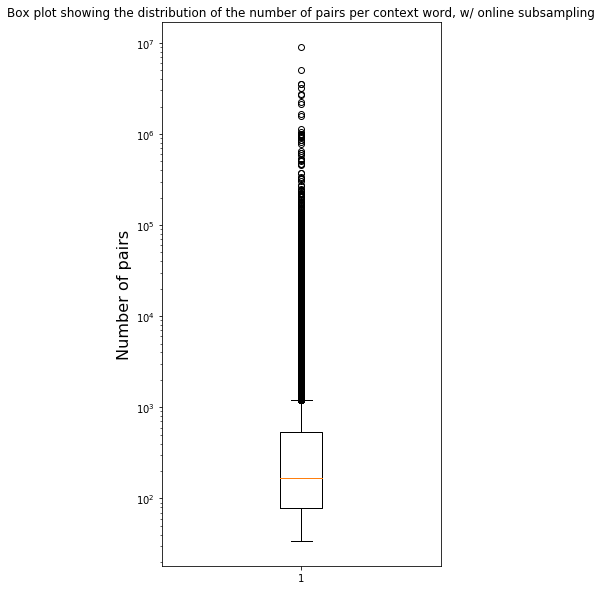

In [143]:
plt.rcParams['figure.figsize'] = [5,10]
plt.yscale('log')
plt.title('Box plot showing the distribution of the number of pairs per context word, w/ online subsampling')
plt.ylabel('Number of pairs', fontsize=16)
B = plt.boxplot(len_lists)
B

In [20]:
l = []
for i in range(0,253854,9402):
    print(i,len_lists[i])
    l.append(len_lists[i])
l.append(len_lists[253853])
#print(l)

0 5
9402 5
18804 6
28206 7
37608 8
47010 8
56412 9
65814 10
75216 10
84618 10
94020 10
103422 10
112824 10
122226 14
131628 16
141030 18
150432 20
159834 25
169236 29
178638 35
188040 45
197442 58
206844 81
216246 122
225648 205
235050 410
244452 1169


In [19]:
len_lists[253853]

360354

In [16]:
l= []
for i in range(0,253854,100):
    print(i,len_lists[i])
    l.append([i,len_lists[i]])
l.append([243853,len_lists[253853]])


0 5
100 5
200 5
300 5
400 5
500 5
600 5
700 5
800 5
900 5
1000 5
1100 5
1200 5
1300 5
1400 5
1500 5
1600 5
1700 5
1800 5
1900 5
2000 5
2100 5
2200 5
2300 5
2400 5
2500 5
2600 5
2700 5
2800 5
2900 5
3000 5
3100 5
3200 5
3300 5
3400 5
3500 5
3600 5
3700 5
3800 5
3900 5
4000 5
4100 5
4200 5
4300 5
4400 5
4500 5
4600 5
4700 5
4800 5
4900 5
5000 5
5100 5
5200 5
5300 5
5400 5
5500 5
5600 5
5700 5
5800 5
5900 5
6000 5
6100 5
6200 5
6300 5
6400 5
6500 5
6600 5
6700 5
6800 5
6900 5
7000 5
7100 5
7200 5
7300 5
7400 5
7500 5
7600 5
7700 5
7800 5
7900 5
8000 5
8100 5
8200 5
8300 5
8400 5
8500 5
8600 5
8700 5
8800 5
8900 5
9000 5
9100 5
9200 5
9300 5
9400 5
9500 5
9600 5
9700 5
9800 5
9900 5
10000 5
10100 5
10200 5
10300 5
10400 5
10500 5
10600 5
10700 5
10800 5
10900 5
11000 5
11100 5
11200 5
11300 5
11400 5
11500 5
11600 5
11700 5
11800 5
11900 6
12000 6
12100 6
12200 6
12300 6
12400 6
12500 6
12600 6
12700 6
12800 6
12900 6
13000 6
13100 6
13200 6
13300 6
13400 6
13500 6
13600 6
13700 6
13800 6


198000 60
198100 60
198200 60
198300 60
198400 60
198500 61
198600 61
198700 61
198800 61
198900 61
199000 62
199100 62
199200 62
199300 62
199400 62
199500 63
199600 63
199700 63
199800 63
199900 64
200000 64
200100 64
200200 64
200300 64
200400 65
200500 65
200600 65
200700 65
200800 65
200900 66
201000 66
201100 66
201200 66
201300 66
201400 67
201500 67
201600 67
201700 67
201800 68
201900 68
202000 68
202100 68
202200 69
202300 69
202400 69
202500 69
202600 70
202700 70
202800 70
202900 70
203000 71
203100 71
203200 71
203300 71
203400 72
203500 72
203600 72
203700 72
203800 73
203900 73
204000 73
204100 73
204200 74
204300 74
204400 74
204500 74
204600 75
204700 75
204800 75
204900 76
205000 76
205100 76
205200 76
205300 77
205400 77
205500 77
205600 78
205700 78
205800 78
205900 78
206000 79
206100 79
206200 79
206300 80
206400 80
206500 80
206600 81
206700 81
206800 81
206900 81
207000 82
207100 82
207200 82
207300 83
207400 83
207500 83
207600 84
207700 84
207800 84
207900 85


In [33]:
print(len_lists[243852])

1074


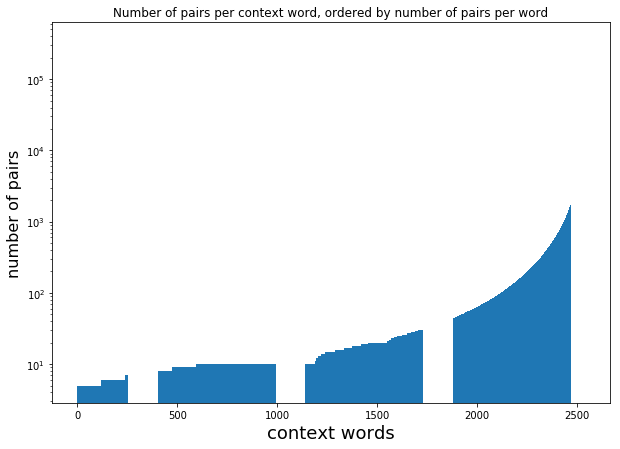

In [18]:
plt.rcParams['figure.figsize'] = [10,7]
plt.title('Number of pairs per context word, ordered by number of pairs per word')
plt.bar(range(len(l)), [val[1] for val in l], align='center')
#plt.xticks(range(len(l)), [val[0] for val in l])
plt.xlabel('context words', fontsize=18)
plt.ylabel('number of pairs', fontsize=16)
#plt.xticks(rotation=70)
plt.yscale('log')
plt.show()

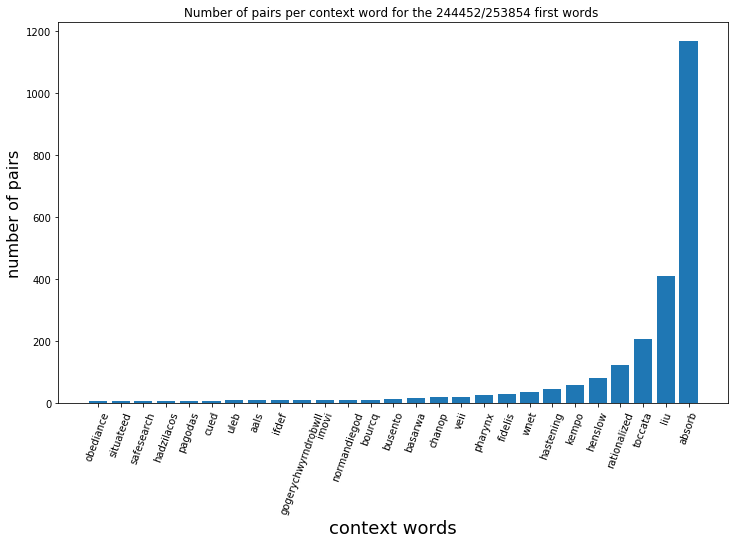

In [46]:
plt.rcParams['figure.figsize'] = [12,7]
plt.title('Number of pairs per context word for the 244452/253854 first words ')
plt.bar(range(len(l)), [val[1] for val in l], align='center')
plt.xticks(range(len(l)), [val[0] for val in l])
plt.xlabel('context words', fontsize=18)
plt.ylabel('number of pairs', fontsize=16)
plt.xticks(rotation=70)
plt.show()

In [31]:
print( "mean = " + str(statistics.mean(len_lists)))
print( "median = " + str(statistics.median(len_lists)))
print( "minimum = " + str(statistics.min(len_lists)))

mean = 292.75764021839325
median = 15.0


AttributeError: module 'statistics' has no attribute 'min'

In [ ]:
#Median
w2v = W2V(ds, neg_samples=10, alpha=0.0075,shuffle=True)
w2v.train_with_loader()


cuda:0
starting training


In [7]:
# Creating whole datasety
enwik9_wDataset = wDataSet((enwik9),ctx_window=5)

Creating vocab


In [8]:
w2v = W2V(enwik9_wDataset, neg_samples=5, alpha=0.001,shuffle=True)
w2v.train_with_loader()

cuda:0
starting training
0%==========100%, Time:  02:57:43.88, cum_loss = 542836.375
1 epoch of 20
 244696 244697 batches, pairs 489393510, cum loss: 542851.43750
Current score on wordsim Task: 0.6580580246735275
0%==========100%, Time:  02:57:25.32, cum_loss = 524791.9375
2 epoch of 20
 244696 244697 batches, pairs 489393510, cum loss: 524807.06250
Current score on wordsim Task: 0.6651399366885339
0%==========100%, Time:  02:42:56.22, cum_loss = 523478.125
3 epoch of 20
 244696 244697 batches, pairs 489393510, cum loss: 523493.21875
Current score on wordsim Task: 0.6644381396072672
0%==========100%, Time:  02:58:48.60, cum_loss = 523088.78125
4 epoch of 20
 244696 244697 batches, pairs 489393510, cum loss: 523103.78125
Current score on wordsim Task: 0.6716186405794663
0%==========100%, Time:  03:02:41.59, cum_loss = 523442.575
5 epoch of 20
 244696 244697 batches, pairs 489393510, cum loss: 523457.53125
Current score on wordsim Task: 0.676185051156628
0%==========100%, Time:  02:55:46

In [13]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [33]:
w2v.save_embedding()

ntm
Saving embedding: dict_emb_OptimAdam_momentum0_nesterovFalse_step_size1_gamma1_shuffleTrue_batch_size2000_alpha0.001_dim100_workers1_ctxw5_neg_samples5_use_cudaTrue_iterations20.pkl to disk with ws_score: [0.6651699513300704, 0.6644982110172235] 


In [31]:
score = -1*(wordsim_task(w2v.get_embedding())[0][1])
w2v.ws_list.append(score)


In [ ]:
ws_lists=[]
for i in range(10):
    w2v = W2V(enwik9_wDataset, neg_samples=5, alpha=0.001,batch_size=30,iterations=2)
    w2v.train_with_loader()
    ws_lists.append(np.array(w2v.ws_list))
mean_list = [np.mean(x) for x in zip(* ws_lists)]
with open("mean_list_adam_10runs_enwik9", 'wb') as output:
    pickle.dump(mean_list, output, pickle.HIGHEST_PROTOCOL)
with open("mean_list_adam_10runs_enwik9", 'wb') as output:
    pickle.dump(ws_lists, output, pickle.HIGHEST_PROTOCOL)

cuda:0
starting training


In [1]:
import pickle
import torch
with open("mean_list_adam_iter10", 'rb') as output:
        mean_list = pickle.load(output)
mean_list

[0.6257743894841544,
 0.6705295692422975,
 0.6804812375824623,
 0.6810218187331774,
 0.6789483524873088,
 0.676725395051269,
 0.6769424838360802,
 0.6753655497078557,
 0.6728324299609623,
 0.672059632651494]

In [10]:
import pickle
import torch
import numpy as np
with open("ws_lists_gensim", 'rb') as output:
        ws_lists = pickle.load(output)
mean_list = [np.mean(x) for x in zip(* ws_lists)]
mean_list


[0.538406581419507,
 0.6228384775172953,
 0.6515852681869152,
 0.6629197884943001,
 0.6663014320112144,
 0.6652439726413314]

### EVALUATION

In [32]:
import pickle
import torch
with open("dict_emb_w2vbs7000_neg7_dim100_epochs20_ctxw10_alpha0-075decayhalf.pkl", 'rb') as output:
        dict_emb = pickle.load(output)

ImportError: No module named 'torch'

In [57]:
from scipy import spatial

x = spatial.distance.cosine(gensim_emb['love'], gensim_emb['music'])
y = spatial.distance.cosine(gensim_emb['anarchism'],gensim_emb['music'])
z = spatial.distance.cosine(gensim_emb['revolution'],gensim_emb['creatine'])

l = ['music','anarchism','revolution','philosophy','creatine']
print(x)
print(y)
z

0.30364346504211426
0.45958149433135986


0.5577877461910248

In [10]:
dict_emb.pop('loss_list')

[tensor(5.5450, requires_grad=True),
 tensor(5.5439, requires_grad=True),
 tensor(5.5429, requires_grad=True),
 tensor(5.5426, requires_grad=True),
 tensor(5.5412, requires_grad=True),
 tensor(5.5425, requires_grad=True),
 tensor(5.5414, requires_grad=True),
 tensor(5.5402, requires_grad=True),
 tensor(5.5409, requires_grad=True),
 tensor(5.5391, requires_grad=True),
 tensor(5.5376, requires_grad=True),
 tensor(5.5360, requires_grad=True),
 tensor(5.5368, requires_grad=True),
 tensor(5.5365, requires_grad=True),
 tensor(5.5357, requires_grad=True),
 tensor(5.5351, requires_grad=True),
 tensor(5.5354, requires_grad=True),
 tensor(5.5333, requires_grad=True),
 tensor(5.5336, requires_grad=True)]

In [59]:
gensim_emb = dict()
for sentences in text8_dataset:
    for word in sentences:
        gensim_emb[word] = model.wv[word]

In [9]:
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec
vocab = set(text8_ds1)
gensim_emb = dict()

    
class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.cum_loss = 0
        self.loss_list = []
        self.ws_list = []
        self.prev_score = -1
        self.no_improvement =0


    def on_epoch_end(self, model):
        for word in vocab:
            gensim_emb[word] = model.wv[word]
            
        score = -1*wordsim_task(gensim_emb)[0][1]
        self.ws_list.append(score)
        
        if(score - self.prev_score < 0.0009):
            self.no_improvement +=1
            
        print("Epoch #{} end: cum_loss={}, ws_score={}".format(self.epoch,self.cum_loss,score))
        
        
        if(self.no_improvement == 2):
            print("No improvement in word similarity early stoppage")
            
            
            
        self.epoch += 1
        self.prev_score = score
    
    def on_batch_end(self, model):
        """Method called at the end of each batch.
        Parameters
        ----------
        model : :class:`~gensim.models.base_any2vec.BaseWordEmbeddingsModel`
            Current model.
        """
        self.cum_loss += model.get_latest_training_loss()
        



NameError: name 'text8_ds1' is not defined

In [23]:
def get_distances(word):
    for x in dict_emb.keys():
        yield(x, spatial.distance.cosine(dict_emb[word],dict_emb[x]))

In [54]:
n_dict_emb = {(word): (x / np.linalg.norm(x)) for (word, x) in (dict_emb.items())}
n_dict_emb_gensim = {(word): (x / np.linalg.norm(x)) for (word, x) in (gensim_emb.items())}

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

### ANALOGY TASK

In [ ]:
file = open("./data/questions-words.txt")
questions = file.readlines()
qeustions_vocab = set()
for i,x in enumerate(questions): 
    questions[i] = x.rstrip("\n").split()
    if x[0]==':':
        del questions[i]
    else: 
        for word in x:
            questions_vocab.add(y)



In [6]:
def read_in_chunks(file_object, chunk_size=1024):
    """Lazy function (generator) to read a file piece by piece.
    Default chunk size: 1k."""
    while True:
        data = file_object.read(chunk_size)
        if not data:
            break
        yield data


In [11]:
file = open("./data/enwik9")
enwik9 = read_in_chunks(file)
l = []
for x in enwik9:
    l.append(x)


['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english']

In [13]:
file = open("./data/questions-words.txt")
questions = file.readlines()

'social relations based upon voluntary association of autonomous individuals mutual aid and self governance while anarchism is most easily defined by what it is against anarchists also offer positive visions of what they believe to be a truly free society however ideas about how an anarchist society might work vary considerably especially with respect to economics there is also disagreement about how a free society might be brought about origins and predecessors kropotkin and others argue that before recorded history human society was organized on anarchist principles most anthropologists follow kropotkin and engels in believing that hunter gatherer bands were egalitarian and lacked division of labour accumulated wealth or decreed law and had equal access to resources william godwin anarchists including the the anarchy organisation and rothbard find anarchist attitudes in taoism from ancient china kropotkin found similar ideas in stoic zeno of citium according to kropotkin zeno repudia

In [8]:
#TODO: logging, save loss, batch_size
epoch_logger = EpochLogger()
model = Word2Vec(l, size=100,window=5,negative=10, alpha=0.01, min_count=5, workers=4,sg=1, callbacks=[epoch_logger],compute_loss=True)


NameError: name 'EpochLogger' is not defined

In [19]:
def analogy_task(questions,dict_emb):
    score = []
    if all(word in dict_emb for word in questions):
        y = dict_emb[questions[0]] -  dict_emb[questions[1]] +  dict_emb[questions[2]]
        x = get_closest_with_score(dict_emb,y)
        if x == questions[3]:
            score.append(1)
        else: 
            score.append(0)
    return score
        

In [31]:
import numpy as np
# TODO: calculate closest only for a given set of words to get faster computation for analogy task
def calculate_sim(dict_emb): 
    # Create dictionnary with id for every word, this is needed because sometimes we only have access to the dict_emb
    # and not the whole model 
    idx2word = {idx: w for (idx, w) in enumerate(dict_emb.keys())}
    word2idx = {w: idx for (idx, w) in enumerate(dict_emb.keys())}
    
    emb_size = len(next(iter(dict_emb.values())))
    
    # Create an embedding dictionnary with normalized vectors
    normalized_dict_emb = {(word): (x / np.linalg.norm(x)) for (word, x) in (dict_emb.items())}
    
    # Create an vocab_size*emb_size Matrix that holds the normalized embeding of each word in it's row called matrix_row
    # Create an emb_size*vocab_size Matrix that holds the normalized embeding of each word in it's colomn  matrix_colomn
    for i in range(0,len(dict_emb.keys())):
        y = normalized_dict_emb[idx2word[i]]
        if i ==0:
            matrix_colomn = torch.tensor(y).view(emb_size,1)
            matrix_row = torch.tensor(y)
        else:
            matrix_colomn = torch.cat([matrix_colomn,torch.tensor(y).view(emb_size,1)],1)
            matrix_row = torch.cat([matrix_row,torch.tensor(y)])
    
    matrix_row = matrix_row.view(-1,emb_size)
    
    matrix_row = matrix_row.to(device)
    matrix_colomn = matrix_colomn.to(device)
    
    return 1-(torch.matmul(matrix_row,matrix_colomn)),word2idx






    

In [221]:
import random
def get_closest(score_dict, word):
    closest = ()
    distance = 3
    for (x,y),score in score_dict.items():
        #print(x,y,score)
        if((x != y) and ((x==word)or(y==word))):
            if (distance > score):
                closest = (x,y)
                distance = score
    return closest

def get_closest_with_score(dict_emb,y):
    distance = 100
    for x,emb in dict_emb.items():
        if(spatial.distance.cosine(dict_emb[x], dict_emb[y])<distance):
            closest = x
    return x
        

### Visualization of the Data

In [6]:
import os
list_of_files = []
for file in os.listdir("/home/c3dric/model/todo"):
        list_of_files.append(file)
list_of_files.remove('.ipynb_checkpoints')


In [7]:
list_of_files.remove('shuffle_false')

In [8]:
import pickle
file_emb = []
for i,file in enumerate(list_of_files):
    with open("/home/c3dric/model/todo/" + file, 'rb') as output:
        dict_emb = pickle.load(output)
        file_emb.append((file, [float(x) for x in dict_emb['ws_list']]))

In [9]:
len(list_of_files)

4

In [10]:
# Transforming the saved data into a csv file
import re
import csv
with_0 = r'(\w*)alpha(\d.\d*)_\w*'
without_0 = r'(\w*)alpha(\d)_\w*'
sgd_reg = r'(\w*)momentum0_.*'
models_sgd = []
models_adam = []
models_adagrad = []
models_mom = []
models_nag = []
for model in file_emb:
    filename = model[0] 
    if "OptimAdagrad" in filename: 
        models_adagrad.append(model)
    if "OptimAdam" in filename: 
        models_adam.append(model)
    if "OptimSGD" in filename:
        if(re.search(sgd_reg,filename)):
            models_sgd.append(model)
        elif("nesterovFalse" in filename):
            models_mom.append(model)
        else:
            models_nag.append(model)
        
assert(len(file_emb) == len(models_sgd + models_adam + models_adagrad + models_mom + models_nag))

def create_csv(models,csv_file_name):
    lr = []
    lr_scores = []
    epochs = [[] for x in range(20)]
    for model in models:
        filename = model[0]
        if(re.search (without_0,filename)):
            alpha =  int(re.search(without_0,filename).group(2))
            lr_scores.append((alpha,model[1]))
        if(re.search (with_0,filename)):
            alpha =  float(re.search(with_0,filename).group(2))
            lr_scores.append((alpha,model[1]))
    lr_scores = sorted(lr_scores)
    lr = [x[0] for x in lr_scores]
    scores = [x[1] for  x in lr_scores]
    
    for x in lr_scores: 
        ws_scores = x[1]
        for i,score in enumerate(ws_scores):
            epochs[i].append(score)
        for j in range(i+1,20):
            epochs[j].append("")
            
    
    output = [lr] + epochs 
    
    with open(csv_file_name, 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(output)
        csvFile.close()


create_csv(models_adam,"adam.csv")
create_csv(models_adagrad,"adagrad.csv")
create_csv(models_sgd,"sgd.csv")
create_csv(models_mom,"mom.csv")
create_csv(models_nag,"nag.csv")


In [12]:
## Taken from https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/word2vec.ipynb##
import logging
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go

def reduce_dimensions(model,vocab, vocab_plot, plot_in_notebook = True):

    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = []        # positions in vector space
    labels = []         # keep track of words to label our data again later
    for word in vocab:
        vectors.append(model[word])
        labels.append(word)
        
    
    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)
    
    # reduce using t-SNE
    vectors = np.asarray(vectors)
    logging.info('starting tSNE dimensionality reduction. This may take some time.')
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    
    x_vals = [v[0] for i,v in enumerate(vectors) if labels[i] in vocab_plot]
    y_vals = [v[1] for i,v in enumerate(vectors) if labels[i] in vocab_plot]
        
    # Create a trace
    trace = go.Scatter(
        x=x_vals,
        y=y_vals,
        mode='text',
        text=labels
        )
    
    data = [trace]
    
    logging.info('All done. Plotting.')
    
    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')



In [ ]:
money_vocab = 'card luxury gem investor rading earning insuracnce, dividend profit wealth market stock payment money'.split(" ")
foods_vocab = "popcorn fruit eat grocery potato seafood butter cabbage drink wine brandy vodka oil grocery cucumber wine ".split()
print(foods_vocab)
print(money_vocab)
dict_emb.pop("time")
dict_emb.pop("loss_list")
    
reduce_dimensions(dict_emb, dict_emb.keys(),money_vocab + foods_vocab)


['popcorn', 'fruit', 'eat', 'grocery', 'potato', 'seafood', 'butter', 'cabbage', 'drink', 'wine', 'brandy', 'vodka', 'oil', 'grocery', 'cucumber', 'wine']
['card', 'luxury', 'gem', 'investor', 'rading', 'earning', 'insuracnce,', 'dividend', 'profit', 'wealth', 'market', 'stock', 'payment', 'money']


In [11]:

from plotly.offline import init_notebook_mode, iplot, plot
import plotly.plotly as py
import plotly.graph_objs as go


learning_rates = [5e-05, 0.0001,0.00025,0.0005,.00075,.001,0.002,.0025,0.005,0.0075,.01,.025,.05,0.075,0.1,0.25,0.5] + [1,1.5,2,2.5,3,4,5,7.5,10,15,17.5,20,22.5,25,30,32.5,35,40,45,50]
lr_dict = {x: i for i,x in enumerate(learning_rates)}
# SGD
lr_sgd      = [0.00025,0.0005,0.00075,0.001,0.0025,0.005,0.0075,0.01,0.025,0.05]
tr_time_sgd = [20,20,20,20,20,16,11,20,20,20]
lr_sgd_dict = [lr_dict[x] for x in lr_sgd]
assert(len(lr_sgd)== len(tr_time_sgd))
# ADAM
lr_adam = [0.0001,0.0005,0.001,0.005,0.05]
lr_adam_dict = [lr_dict[x] for x in lr_adam]
tr_time_adam = [20,14,5,3,20]
# adagrad
lr_adagrad = [0.00075,0.001,0.05,0.075,0.1,0.25,0.5,1,5]
lr_adagrad_dict = [lr_dict[x] for x in lr_adagrad]
tr_time_adagrad = [20,20,16,13,4,6,11,20,20]
# momentum
lr_mom = [0.0001,0.00025,0.0005,0.00075,0.001,0.002,0.0025,0.005] 
lr_mom_dict = [lr_dict[x] for x in lr_mom]
tr_time_mom = [20,20,13,11,9,20,20,20]
# NAG
lr_nag = [0.00025,0.0005,0.00075,0.001,0.0025,0.005]
lr_nag_dict = [lr_dict[x] for x in lr_nag]
tr_time_nag = [20,15,12,12,20,20]

trace1 = go.Scatter(
    x=lr_sgd_dict,
    y=tr_time_sgd,
    mode='lines+markers',
    name="sgd",
    hoverinfo='name',
    line=dict(
        shape='linear',color='rgb(20,125,190)'
    )
)
trace2 = go.Scatter(
    x= lr_adam_dict,
    y=tr_time_adam,
    mode='lines+markers',
    name="adam",
    hoverinfo='text+name',
    line=dict(
        shape='linear',color='rgb(245,145,30)'
        
    )
)
trace3 = go.Scatter(
    x= lr_adagrad_dict,
    y=tr_time_adagrad,
    mode='lines+markers',
    name="adagrad",
    hoverinfo='text+name',
    line=dict(
        shape='linear',color='rgb(25,160,75)'
    )
)
trace4 = go.Scatter(
    x= lr_mom_dict,
    y=tr_time_mom,
    mode='lines+markers',
    name="momentum",
    hoverinfo='text+name',
    line=dict(
        shape='linear',color='rgb(200,30,135)'
    )
)
trace5 = go.Scatter(
    x= lr_nag_dict,
    y=tr_time_nag,
    mode='lines+markers',
    name="nag",
    hoverinfo='text+name',
    line=dict(
        shape='linear',color='rgb(0,0,0)'
    )
)


data = [trace1,trace2,trace3,trace4,trace5]
layout = dict(title = 'Time to train vs. learning rate, by optimizer',
                 width = 800,
    height = 500,
    xaxis = dict(
        tickvals = list(lr_dict.values()),
        ticktext = list(lr_dict.keys()),
      title = "Learning rate"
    ),
    yaxis=dict(
        type='linear',
        title = 'Training time in number of Epochs',
        tickvals= [1,2,3,4,5,9,11,12,20],
        autorange=True
    )
              )

print(layout["xaxis"]["tickvals"])
fig = dict(data=data, layout=layout)
init_notebook_mode(connected=True)
iplot(fig, filename='word-embedding-plot.html')


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


In [76]:

from plotly.offline import init_notebook_mode, iplot, plot
import plotly.plotly as py
import plotly.graph_objs as go

#learning_rates = [0.00025,0.0005,.00075,.001,0.1,0.25,0.5] + [2.5,5,7.5,10,15,20,22.5]
#lr_dict = {x: i for i,x in enumerate(learning_rates)}
# sgd_shuffle
lr_sgd_shuffle    = [0.00025,0.0005,0.00075,0.001,0.0025,0.005,0.0075,0.01,0.025,0.05,0.075,0.1]
tr_time_sgd_shuffle = [20,20,20,20,20,19,11,11,11,7,20,20]
lr_sgd_shuffle_dict = [lr_dict[x] for x in lr_sgd_shuffle]
assert len(lr_sgd_shuffle) == len(tr_time_sgd_shuffle)

# adam_shuffle
lr_adam_shuffle = [0.0001,0.0005,0.001,0.005,0.05,0.1]
lr_adam_shuffle_dict = [lr_dict[x] for x in lr_adam_shuffle]
tr_time_adam_shuffle = [20,4,2,157,8,15,20,20]
assert len(lr_adam_shuffle) == len(tr_time_adam_shuffle), (str(len(lr_adam_shuffle))+ " "+ str(len(tr_time_adam_shuffle)))

# adagrad_shuffle
lr_adagrad_shuffle = [0.00075,0.001,0.05,0.075,0.1,0.25,0.5,1,2,5]
lr_adagrad_shuffle_dict = [lr_dict[x] for x in lr_adagrad_shuffle]
tr_time_adagrad_shuffle = [20,20,4,3,3,8,20,20,20,20]
assert len(lr_adagrad_shuffle) == len(tr_time_adagrad_shuffle), (str(len(lr_adagrad_shuffle))+ " "+ str(len(tr_time_adagrad_shuffle)))


# mom_suffleentum
lr_mom_suffle = [0.0005,0.00075,0.002,0.0025,0.05] 
lr_mom_suffle_dict = [lr_dict[x] for x in lr_mom_suffle]
tr_time_mom_suffle = [17,12,8,9,20]
assert len(lr_mom_suffle) == len(tr_time_mom_suffle), (str(len(lr_mom_suffle))+ " "+ str(len(tr_time_mom_suffle)))


# nag_shuffle
lr_nag_shuffle = [0.00025,0.0005,0.00075,0.001,0.0025,0.005,0.0075,0.05]
lr_nag_shuffle_dict = [lr_dict[x] for x in lr_nag_shuffle]
tr_time_nag_shuffle = [20,19,9,9,7,3,20,20]
assert len(lr_nag_shuffle) == len(tr_time_nag_shuffle),(str(len(lr_nag_shuffle))+ " "+ str(len(tr_time_nag_shuffle)))




trace1a = go.Scatter(
    x=lr_sgd_shuffle_dict,
    y=tr_time_sgd_shuffle,
    mode='lines+markers',
    name="sgd_shuffle",
    hoverinfo='name',
    line=dict(
        shape='linear',dash='dot',color='rgb(20,125,190)'
    )
)
trace2a = go.Scatter(
    x= lr_adam_shuffle_dict,
    y=tr_time_adam_shuffle,
    mode='lines+markers',
    name="adam_shuffle",
    hoverinfo='text+name',
    line=dict(
        shape='linear',dash='dot',color='rgb(245,145,30)'
        
    )
)
trace3a = go.Scatter(
    x= lr_adagrad_shuffle_dict,
    y=tr_time_adagrad_shuffle,
    mode='lines+markers',
    name="adagrad_shuffle",
    hoverinfo='text+name',
    line=dict(
        shape='linear',dash='dot',color='rgb(25,160,75)'
    )
)
trace4a = go.Scatter(
    x= lr_mom_suffle_dict,
    y=tr_time_mom_suffle,
    mode='lines+markers',
    name="momentum_suffle",
    hoverinfo='text+name',
    line=dict(
        shape='linear',dash='dot',color='rgb(200,30,135)'
    )
)
trace5a = go.Scatter(
    x= lr_nag_shuffle_dict,
    y=tr_time_nag_shuffle,
    mode='lines+markers',
    name="nag_shuffle",
    hoverinfo='text+name',
    line=dict(
        shape='linear',dash='dot',color='rgb(0,0,0)'
    )
)
data_a = [trace1a,trace2a,trace3a,trace4a,trace5a] 
data = data + data_a
layout = dict(title = 'Time to train vs. learning rate, by optimizer',
                 width = 800,
    height = 500,
    xaxis = dict(
        tickvals = list(lr_dict.values()),
        ticktext = list(lr_dict.keys()),
      title = "Learning rate"
    ),
    yaxis=dict(
        type='linear',
        title = 'Training time in number of Epochs',
        tickvals=[1,2,3,7,8,15,20],
        autorange=True
    )
              )

fig = dict(data=data, layout=layout)
fig1 = dict(data=data_a, layout=layout)
init_notebook_mode(connected=True)
#iplot(fig, filename='word-embedding-plot')
iplot(fig1, filename='word-embedding-plot')



In [80]:
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.plotly as py
import plotly.graph_objs as go
gensim_conv = [0,0.47 ,0.59,0.63,0.637,0.649, 0.64991,0.653,0.664,0.6655,0.6615,0.6629,0.663] 
adam_conv = [0,0.5274663249,0.6317800941,0.6661224712,0.6663352711,0.6692290085, 0.6709985856, 0.6687059277, 0.6676404941]
adam_shuffle_conv = [0,0.6209724591, 0.6648207026,0.6608316399,0.6653500479,0.6667224712]
sgd_conv = [0,0.2656567075,0.409453666,0.4961671944,0.5470711378,0.58201276,0.608320445,0.6224159501,0.6369093127,0.6457120334,0.653658488,0.6585042924,0.6608316399]
sgd_shuffle_conv = [0,0.3979027932,0.5345590809,0.5957749206,0.6150409906,0.6343477449,0.6408864911,0.6569273384,0.6638613219,0.664644281,0.6684268463,0.6676506492]

epoches = list(range(20))
trace1 = go.Scatter(
    x=epoches,
    y=gensim_conv,
    mode='lines+markers',
    name="gensim",
    hoverinfo='name',
    line=dict(
        shape='linear',color='rgb(139,0,0)'
    )
)
trace2 = go.Scatter(
    x= epoches,
    y=sgd_shuffle_conv,
    mode='lines+markers',
    name="SGD_shuffle",
    hoverinfo='text+name',
    line=dict(
        shape='linear',dash='dot',color='rgb(20,125,190)'
        
    )
)
trace3 = go.Scatter(
    x=epoches,
    y=sgd_conv,
    mode='lines+markers',
    name="gensim",
    hoverinfo='name',
    line=dict(
        shape='linear',color='rgb(20,125,190)'
    )
)
trace4 = go.Scatter(
    x= epoches,
    y=adam_shuffle_conv,
    mode='lines+markers',
    name="adam_shuffle",
    hoverinfo='text+name',
    line=dict(
        shape='linear',dash='dot',color='rgb(245,145,30)'
        
    )
)
trace5 = go.Scatter(
    x= epoches,
    y=adam_conv,
    mode='lines+markers',
    name="adam_shuffle",
    hoverinfo='text+name',
    line=dict(
        shape='linear',color='rgb(245,145,30)'
        
    )
)

data = [trace1,trace2,trace3,trace4,trace5]
layout = dict(title = 'Convergence time comparison',
                 width = 800,
    height = 500,
    xaxis = dict(
      title = 'Training time in number of Epochs'
    ),
    yaxis=dict(
        type='linear',
        title = "Word similarity",
             autorange=True
    )
              )

fig = dict(data=data, layout=layout)
init_notebook_mode(connected=True)
iplot(fig, filename='word-embedding-plot.html')
